# Final Project Submission

Please fill out:
* Student name: __Paul Williams__
* Student pace: __full time__
* Scheduled project review date/time: __03/23/2020__
* Instructor name: __Dave Baker__

# Data Cleaning

## Imports:

In [1]:
# Data Frame & Visualization libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and regression libraries
import math
import statistics as stats
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# train test imports

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_validate


import warnings
warnings.filterwarnings('ignore')

/Users/paulwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## The Data set

In [2]:
housing_df = pd.read_csv('data-files/kc_house_data.csv')
print("--------------------------------------------------")
print("Number of row's before cleaning: ", housing_df.shape[0])
print("Number of columns before cleaning: ", housing_df.shape[1])
print("--------------------------------------------------")
housing_df.head(3)

--------------------------------------------------
Number of row's before cleaning:  21597
Number of columns before cleaning:  21
--------------------------------------------------


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


In [3]:
# Data types for each columns
print(housing_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Missing Values

In [4]:
print("Total missing values:", housing_df.isnull().sum().sum()) # I am not using yr_renovated in my model so i will just ignore the nulls
print("--------------------------------------------------")
housing_df.isnull().sum()

Total missing values: 6281
--------------------------------------------------


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Dealing with them:

In [5]:
print("Waterfront's values:", list(housing_df.waterfront.unique()))

Waterfront's values: [nan, 0.0, 1.0]


I think that the missing values for waterfront was due to lazy data entry and the person entering data probably thought putting nothing into the column is the same as saying 0. I will replace my null values in this column with 0.0.

In [6]:
housing_df['waterfront'].fillna(value=0.0, inplace=True)

In [7]:
print("Total waterfront missing values now: ", housing_df['waterfront'].isna().sum())

Total waterfront missing values now:  0


# Exploratory Data Analysis

## Check Duplicates

In [8]:
# We need to check if our ID's are duplicated because that would mean we may have the same houses
print("There are", housing_df['id'].duplicated().sum(), "duplicate entries")

There are 177 duplicate entries


In [9]:
print("Number of houses duplicated: ", housing_df['id'].duplicated().sum())


Number of houses duplicated:  177


In [10]:
housing_df['is_duplicated'] = housing_df['id'].duplicated()
housing_df.query('is_duplicated== True').loc[:, ['id', 'date','price', 'is_duplicated']].sort_values('id')

,id,date,price,is_duplicated
2495,1000102,4/22/2015,300000.0,True
16801,7200179,4/24/2015,175000.0,True
11422,109200390,10/20/2014,250000.0,True
12406,123039336,12/8/2014,244900.0,True
7786,251300110,1/14/2015,358000.0,True
...,...,...,...,...
2492,9407110710,2/26/2015,322000.0,True
4918,9809000020,3/13/2015,1940000.0,True
6340,9828200460,1/6/2015,430000.0,True
15186,9834200305,2/10/2015,615000.0,True


## Drop duplicates:

In [11]:
housing_df.drop_duplicates(subset='id', keep="last", inplace=True)

In [12]:
print("Number of houses duplicated after drop: ", housing_df['id'].duplicated().sum())

Number of houses duplicated after drop:  0


## Outliers

In [13]:
housing_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.142000e+04,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21357.000000,21420.000000,21420.000000,21420.000000,21420.000000,17607.000000,21420.00000,21420.000000,21420.000000,21420.000000,21420.000000
mean,4.580940e+09,5.418614e+05,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.006816,0.234677,3.410784,7.662792,1791.170215,1971.092997,83.890101,98077.87437,47.560197,-122.213784,1988.384080,12775.718161
std,2.876761e+09,3.675569e+05,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.082280,0.766459,0.650035,1.171971,828.692965,29.387141,400.534473,53.47748,0.138589,0.140791,685.537057,27345.621867
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.00000,47.155900,-122.519000,399.000000,651.000000
25%,2.123537e+09,3.249500e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,1952.000000,0.000000,98033.00000,47.471200,-122.328000,1490.000000,5100.000000
50%,3.904921e+09,4.505500e+05,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.00000,47.572100,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,1997.000000,0.000000,98117.00000,47.678100,-122.125000,2370.000000,10086.250000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.00000,47.777600,-121.315000,6210.000000,871200.000000


33 bedrooms seems suspicious

In [14]:
housing_df.query('bedrooms==33')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_duplicated
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,False


I dont think 33 people can share 2 bathrooms. Likely a data entry error. So lets find similar dimension houses to it and fill it with the median amount of bedrooms.

In [15]:
print("Query out houses with similar dimensions to our outlier then take the median bedrooms for those dimensions, the median ignores the fact that the outlier is actually in this list:")
print("--------------------------------------------------")
median_outlier = housing_df.query("bathrooms<=1.75 and sqft_living<2000 and floors==1").median()
median_outlier

Query out houses with similar dimensions to our outlier then take the median bedrooms for those dimensions, the median ignores the fact that the outlier is actually in this list:
--------------------------------------------------


id               3.852900e+09
price            3.300000e+05
bedrooms         3.000000e+00
bathrooms        1.000000e+00
sqft_living      1.270000e+03
sqft_lot         7.740000e+03
floors           1.000000e+00
waterfront       0.000000e+00
view             0.000000e+00
condition        3.000000e+00
grade            7.000000e+00
sqft_above       1.100000e+03
yr_built         1.955000e+03
yr_renovated     0.000000e+00
zipcode          9.810300e+04
lat              4.755090e+01
long            -1.222880e+02
sqft_living15    1.490000e+03
sqft_lot15       7.790000e+03
is_duplicated    0.000000e+00
dtype: float64

In [16]:
print("Median bedrooms for houses with those dimensions is: ", int(median_outlier[2]))

Median bedrooms for houses with those dimensions is:  3


3 bedrooms is the median for houses similar to our outlier. This sounds more realistic and it was likely a data entry typo.

## Fill outlier

In [17]:
housing_df.query('bedrooms==33')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_duplicated
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,False


In [18]:
housing_df['bedrooms'].replace(33, median_outlier[2], inplace=True)

## Drop unneeded columns

In [19]:
# Run this cell only once 
columns = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'is_duplicated']
new_housing_df= housing_df.drop(axis=1, columns=columns)
print("--------------------------------------------------")
print("Number of columns before the drop: ", housing_df.shape[1])
print("Number of columns after the drop: ", new_housing_df.shape[1])
print("--------------------------------------------------")
new_housing_df.head(3)

--------------------------------------------------
Number of columns before the drop:  22
Number of columns after the drop:  11
--------------------------------------------------


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933


In [20]:
print("--------------------------------------------------")
print("Final amount of rows: ", new_housing_df.shape[0])
print("Final amount of columns: ", new_housing_df.shape[1])
print("--------------------------------------------------")

--------------------------------------------------
Final amount of rows:  21420
Final amount of columns:  11
--------------------------------------------------


## Question 1
What is the relationship between my variables like?

### Visualization 1

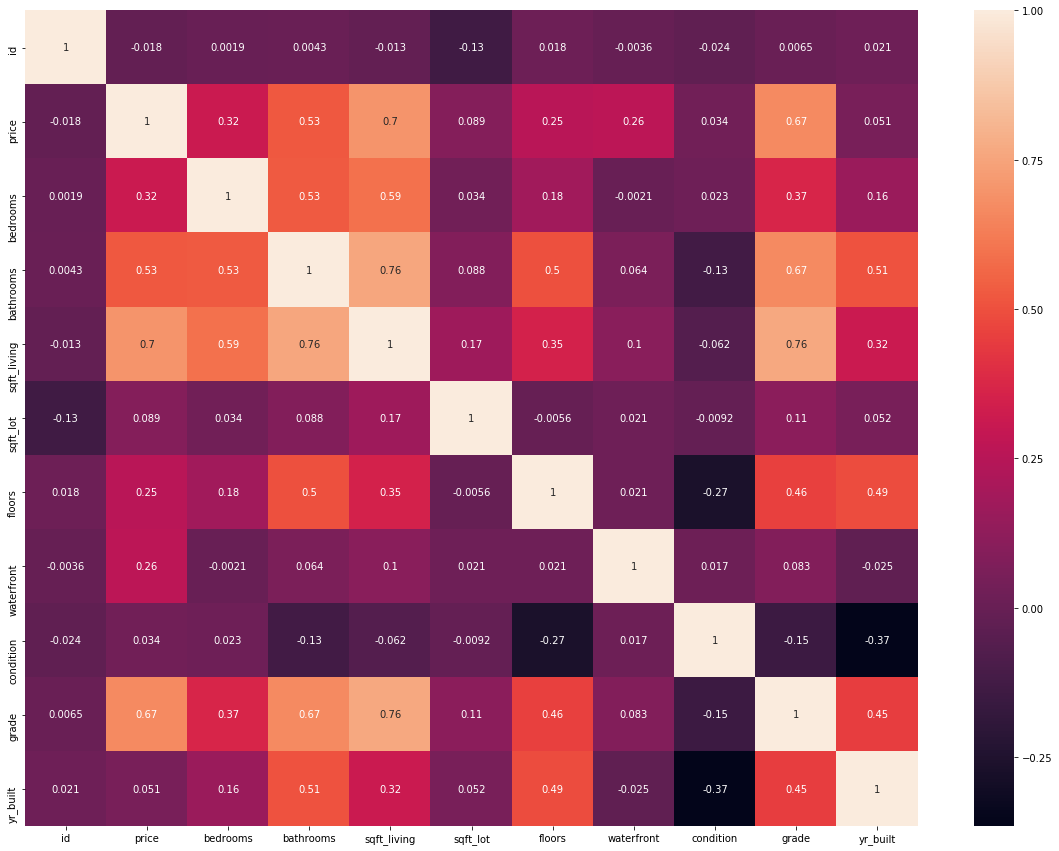

In [21]:
plt.subplots(figsize=(20,15))
sns.heatmap(new_housing_df.corr(), annot=True)
plt.show()

Sqft_living seems to correlate the highest with price. We can attempt to build our model around this. To avoid multi-colinearity we wil pick 2 other variables for our model that correlate well with price and don't correlate at a .7 or above with sqft_living.

In [22]:
new_housing_df.loc[:, ['price', 'sqft_living', 'waterfront', 'bedrooms']].corr() # my baseline regression features

,price,sqft_living,waterfront,bedrooms
price,1.000000,0.701295,0.264915,0.316910
sqft_living,0.701295,1.000000,0.104737,0.594221
waterfront,0.264915,0.104737,1.000000,-0.002132
bedrooms,0.316910,0.594221,-0.002132,1.000000


These features seem to be my best bet. They correlate decently with price while staying under .7 with sqft_living.

## Question 2
Does having more bathrooms than bedrooms make the price of a house more expensive? If so does this prove a potential better group of predictors that also manage to encompass sqft_living without directly including it?


To tackle this question i will round up my bathrooms into a total room count. This is because having a .25 bathroom means you have 1 full room with just a toilet and sink. Having a .5 bathroom means you have 1 full room with 2 plumbing fixtures etc. I will consider Bathrooms like this as additional rooms.

In [23]:
bed_bath_df = new_housing_df.loc[:,['price', 'bathrooms', 'bedrooms']]
bed_bath_df['bathroom_count']= bed_bath_df['bathrooms'].apply(np.ceil)
bed_bath_df['total_room_count']= bed_bath_df['bedrooms']+bed_bath_df['bathroom_count']
bed_bath_df

,price,bathrooms,bedrooms,bathroom_count,total_room_count
0,221900.0,1.00,3,1.0,4.0
1,538000.0,2.25,3,3.0,6.0
2,180000.0,1.00,2,1.0,3.0
3,604000.0,3.00,4,3.0,7.0
4,510000.0,2.00,3,2.0,5.0
...,...,...,...,...,...
21592,360000.0,2.50,3,3.0,6.0
21593,400000.0,2.50,4,3.0,7.0
21594,402101.0,0.75,2,1.0,3.0
21595,400000.0,2.50,3,3.0,6.0


In [24]:
house_group1 = bed_bath_df.query('bathroom_count>=bedrooms')
print("There are ", len(house_group1),"Entries in this category")
print("--------------------------------------------------")
house_group_1_corr = house_group1.corr()
stats_house_group_1 = house_group1.describe()
stats_house_group_1

There are  6591 Entries in this category
--------------------------------------------------


,price,bathrooms,bedrooms,bathroom_count,total_room_count
count,6.591000e+03,6591.000000,6591.000000,6591.000000,6591.000000
mean,6.333343e+05,2.581323,2.931422,3.068882,6.000303
std,4.788516e+05,0.701522,0.703018,0.751400,1.409269
min,8.000000e+04,0.500000,1.000000,1.000000,2.000000
25%,3.625000e+05,2.250000,3.000000,3.000000,6.000000
50%,5.010000e+05,2.500000,3.000000,3.000000,6.000000
75%,7.250000e+05,2.750000,3.000000,3.000000,6.000000
max,7.700000e+06,8.000000,7.000000,8.000000,15.000000


In [25]:
house_group2 = bed_bath_df.query('bathroom_count<=bedrooms')
print("There are ", len(house_group2),"Entries in this category")
print("--------------------------------------------------")
house_group_2_corr = house_group2.corr()
stats_house_group2 = house_group2.describe()
stats_house_group2

There are  20557 Entries in this category
--------------------------------------------------


,price,bathrooms,bedrooms,bathroom_count,total_room_count
count,2.055700e+04,20557.000000,20557.000000,20557.000000,20557.000000
mean,5.292871e+05,2.074208,3.401226,2.389308,5.790534
std,3.361889e+05,0.730200,0.894533,0.882727,1.571758
min,7.800000e+04,0.500000,1.000000,1.000000,2.000000
25%,3.200000e+05,1.500000,3.000000,2.000000,5.000000
50%,4.499500e+05,2.250000,3.000000,3.000000,6.000000
75%,6.350000e+05,2.500000,4.000000,3.000000,7.000000
max,7.060000e+06,7.500000,11.000000,8.000000,17.000000


In [26]:
print("More Bath than Bed tend to cost: $",round(house_group1['price'].mean(),2),"on average")
print("Less Bath than Bed tend to cost: $",round(house_group2['price'].mean(),2),"on average")
print("--------------------------------------------------------")
print("The difference in average house group price is: $", round(house_group1['price'].mean()-house_group2['price'].mean(),2))

More Bath than Bed tend to cost: $ 633334.3 on average
Less Bath than Bed tend to cost: $ 529287.08 on average
--------------------------------------------------------
The difference in average house group price is: $ 104047.22


In [27]:
print("The correlation between price and bedrooms in this group has gone up:")
print("------------------------------------------------------------------------")
house_group_1_corr.loc[:,['price','bedrooms', 'bathroom_count']] # Check the correlation of these groups for clarity

The correlation between price and bedrooms in this group has gone up:
------------------------------------------------------------------------


,price,bedrooms,bathroom_count
price,1.000000,0.476498,0.543171
bathrooms,0.583658,0.840752,0.956771
bedrooms,0.476498,1.000000,0.877622
bathroom_count,0.543171,0.877622,1.000000
total_room_count,0.527313,0.966787,0.970988


In [28]:
print("The correlation between price and bedrooms in this group isn't as high as the other:")
print("--------------------------------------------------------------------------------------")
house_group_2_corr.loc[:,['price','bedrooms', 'bathroom_count']]

The correlation between price and bedrooms in this group isn't as high as the other:
--------------------------------------------------------------------------------------


,price,bedrooms,bathroom_count
price,1.000000,0.341176,0.466909
bathrooms,0.497385,0.588197,0.966595
bedrooms,0.341176,1.000000,0.564208
bathroom_count,0.466909,0.564208,1.000000
total_room_count,0.456397,0.885998,0.882724


The correlation goes up with bedrooms and price in these groups. This could mean that bedrooms with a combination of bathroom count are better predictors than sqft_living. Yes higher amount of these rooms would encompass a higher sqft_living. I would be more willing to put my money on these predictors.

### Visualization 2
Bar chart comparing Houses with more bathrooms than bedrooms with houses that have less bathrooms than bedrooms

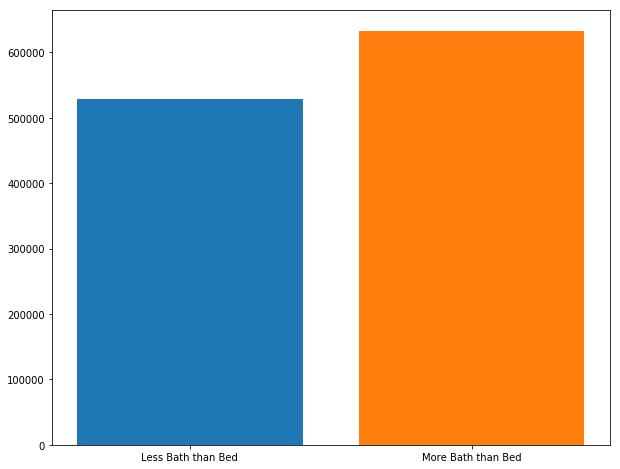

In [29]:
x1 = ["More Bath than Bed"]
y1 = house_group1['price'].mean()
x2 = ["Less Bath than Bed"]
y2 = house_group2['price'].mean()
plt.subplots(figsize=(10,8))
plt.bar(x2,y2)
plt.bar(x1,y1)
plt.show()

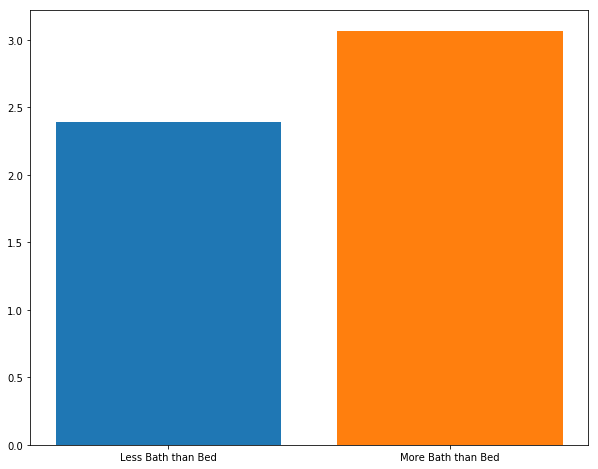

In [30]:
x1 = ["More Bath than Bed"]
y1 = house_group1['bathroom_count'].mean()
x2 = ["Less Bath than Bed"]
y2 = house_group2['bathroom_count'].mean()
plt.subplots(figsize=(10,8))
plt.bar(x2,y2)
plt.bar(x1,y1)
plt.show()

## Question 3

What is the value of having more than 3 bedrooms?

In [31]:
bedrooms_df = new_housing_df.loc[:,['price', 'bedrooms']]
greater_than_3 = bedrooms_df.query('bedrooms>=4')

In [32]:
less_than_4 = bedrooms_df.query('bedrooms<=3')

In [33]:
print("There are ", len(greater_than_3), "Houses with 3 or bedrooms")
print("--------------------------------------------")
mean_greater_than_3 = greater_than_3.describe()
mean_greater_than_3

There are  8761 Houses with 3 or bedrooms
--------------------------------------------


,price,bedrooms
count,8.761000e+03,8761.000000
mean,6.725137e+05,4.266750
std,4.591890e+05,0.573343
min,1.000000e+05,4.000000
25%,3.900000e+05,4.000000
50%,5.650000e+05,4.000000
75%,7.990000e+05,4.000000
max,7.700000e+06,11.000000


In [34]:
print("The mean house price in group 1 is: $", round(mean_greater_than_3['price'][1],2))

The mean house price in group 1 is: $ 672513.73


In [35]:
print("There are ", len(less_than_4), "Houses with 3 or less bedrooms")
print("-------------------------------------------------")
mean_less_than_4 = less_than_4.describe()
mean_less_than_4

There are  12659 Houses with 3 or less bedrooms
-------------------------------------------------


,price,bedrooms
count,1.265900e+04,12659.000000
mean,4.514400e+05,2.753693
std,2.503796e+05,0.464578
min,7.800000e+04,1.000000
25%,2.900000e+05,3.000000
50%,4.010000e+05,3.000000
75%,5.450000e+05,3.000000
max,3.800000e+06,3.000000


In [36]:
print("The mean house price in group 2 is: $", round(mean_less_than_4['price'][1],2))

The mean house price in group 2 is: $ 451440.01


In [37]:
print("Difference in house price between the 2 groups is: $", round(mean_greater_than_3['price'][1]-mean_less_than_4['price'][1],2))

Difference in house price between the 2 groups is: $ 221073.72


### Visualization 3

bar chart comparing group 1 and group 2

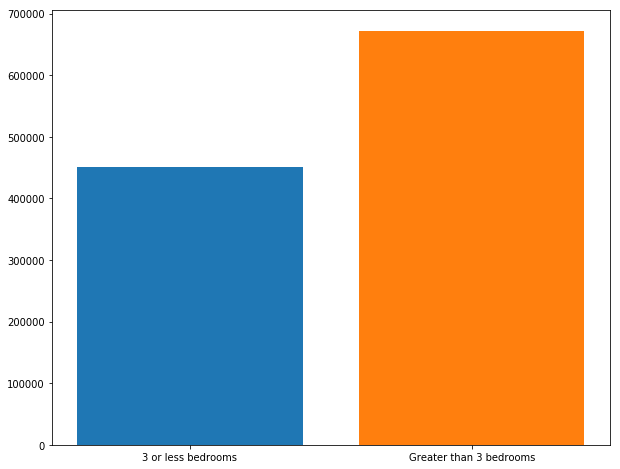

In [38]:
x1 = ["3 or less bedrooms"]
y2 = greater_than_3.mean()
x2 = ["Greater than 3 bedrooms"]
y1 = less_than_4.mean()

plt.subplots(figsize=(10,8))
plt.bar(x1,y1)
plt.bar(x2,y2)
plt.show()

As you can see, Bedroom and Bathroom although they correlate less with price than sqft_living, they could work a bit better as predictors for my linear regression model.

# Regression Model

The sqft living is such a powerful predictor but i feel like it’s not telling the whole truth
and including it makes you run into multi collinearity issues with other predictors. This would mean i would have to drop the other predictors and use sqft living only if i wanted to include it.
I feel like my model would heavily generalize based on the sqft living feature and
if it was given a data set of houses in bad neighbourhoods that had less bathrooms than rooms but high sqft living it would get the price prediction wrong a lot of the time.
so i am thinking of using more predictors with less correlation to price and less correlation with each other and dropping sqft living completely.
I honestly think a combination of bathrooms, bedrooms, and waterfront tell the story better.
So I will run 2 models. My baseline model will include: sqft_living, waterfront, and bedrooms.
And my alternate model will include: bathrooms, waterfront, and bedrooms.

In [39]:
new_housing_df.query('sqft_living>=1000 and bathrooms<=bedrooms and floors>=1').describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,1.918000e+04,1.918000e+04,19180.000000,19180.000000,19180.000000,1.918000e+04,19180.000000,19180.000000,19180.000000,19180.000000,19180.000000
mean,4.579462e+09,5.458094e+05,3.491032,2.148097,2150.121481,1.528439e+04,1.502920,0.005892,3.419864,7.720907,1971.998384
std,2.878784e+09,3.407222e+05,0.845036,0.697944,841.270793,3.998642e+04,0.532305,0.076532,0.648422,1.102141,28.747345
min,1.000102e+06,9.500000e+04,1.000000,0.500000,1000.000000,5.200000e+02,1.000000,0.000000,1.000000,4.000000,1900.000000
25%,2.122540e+09,3.310000e+05,3.000000,1.750000,1520.000000,5.250000e+03,1.000000,0.000000,3.000000,7.000000,1954.000000
50%,3.904921e+09,4.645250e+05,3.000000,2.250000,1990.000000,7.800000e+03,1.500000,0.000000,3.000000,7.000000,1976.000000
75%,7.305451e+09,6.502000e+05,4.000000,2.500000,2590.000000,1.090000e+04,2.000000,0.000000,4.000000,8.000000,1996.000000
max,9.900000e+09,7.060000e+06,11.000000,7.500000,10040.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,2015.000000


In [40]:
new_housing_df.query('sqft_living>=1000 and bathrooms>=bedrooms and floors>=1').describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,1.346000e+03,1.346000e+03,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000
mean,4.727371e+09,7.887196e+05,2.672363,2.976597,2463.586181,19417.223626,1.888559,0.031204,3.226597,8.450966,1987.078009
std,2.950197e+09,6.998005e+05,0.832657,0.918324,1434.350374,66552.868730,0.591943,0.173932,0.538405,1.415597,29.188132
min,7.600136e+06,1.120000e+05,1.000000,1.000000,1000.000000,600.000000,1.000000,0.000000,1.000000,5.000000,1900.000000
25%,2.262350e+09,4.110000e+05,2.000000,2.250000,1440.000000,1778.250000,1.500000,0.000000,3.000000,8.000000,1978.000000
50%,3.903350e+09,5.659750e+05,3.000000,3.000000,1930.000000,5002.000000,2.000000,0.000000,3.000000,8.000000,2001.000000
75%,7.585325e+09,8.637500e+05,3.000000,3.500000,3130.000000,11128.500000,2.000000,0.000000,3.000000,9.000000,2007.000000
max,9.839301e+09,7.700000e+06,7.000000,8.000000,13540.000000,982278.000000,3.500000,1.000000,5.000000,13.000000,2015.000000


## Train/Test split

In [41]:
#pre-processing
#creating dataframe with all the predictor variables
X = new_housing_df.loc[:,['bedrooms','waterfront', 'sqft_living']]

#creating a dataframe with all the target variables
y = new_housing_df['price']
y = pd.DataFrame(y)

In [42]:
print('----------------------')
print('X Shape:', X.shape)
print('y Shape:', y.shape)
print('----------------------')

----------------------
X Shape: (21420, 3)
y Shape: (21420, 1)
----------------------


In [43]:
base_reg = LinearRegression().fit(X, y)
base_reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

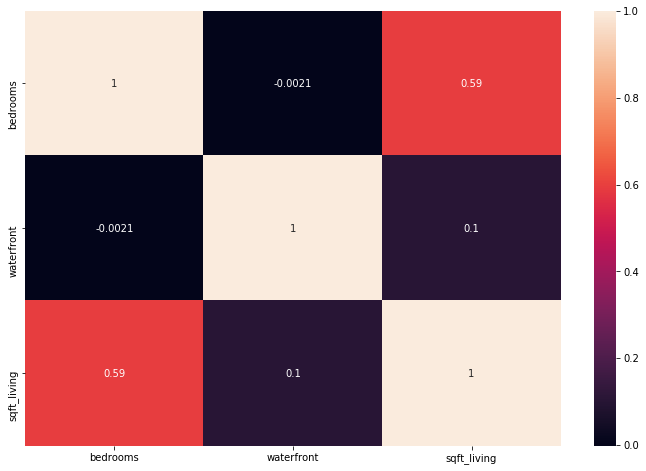

In [44]:
plt.subplots(figsize=(12,8))
sns.heatmap(X.corr(), annot=True)
plt.show()

### Performing the split

In [45]:
#splitting the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.80) # 80 / 20 split
# Scaling the data
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# check the shape
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (17136, 3)
X_test Shape: (4284, 3)
y_train Shape: (17136, 1)
y_test Shape: (4284, 1)


### Baseline Linear Regression

In [47]:
regression_baseline = new_housing_df.loc[:,['price', 'bedrooms','waterfront', 'sqft_living']]
regression_baseline

,price,bedrooms,waterfront,sqft_living
0,221900.0,3,0.0,1180
1,538000.0,3,0.0,2570
2,180000.0,2,0.0,770
3,604000.0,4,0.0,1960
4,510000.0,3,0.0,1680
...,...,...,...,...
21592,360000.0,3,0.0,1530
21593,400000.0,4,0.0,2310
21594,402101.0,2,0.0,1020
21595,400000.0,3,0.0,1600


In [48]:
X = regression_baseline.drop('price',axis=1)
y = regression_baseline['price']

In [49]:
# Setting up the LEARNER
X = sm.add_constant(X_train)
model_sm = sm.OLS(y_train,X)

# Actually LEARNING
results = model_sm.fit()

# Evaluating performance
r2 = results.rsquared
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# # Understanding the LEARNED model
est_b = results.params
print(est_b.round(4))

R2 = 0.54
const           86323.3976
bedrooms       -56028.6573
waterfront     802913.5810
sqft_living       306.9650
dtype: float64


In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     6715.
Date:                Fri, 27 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:00:24   Log-Likelihood:            -2.3747e+05
No. Observations:               17136   AIC:                         4.749e+05
Df Residuals:                   17132   BIC:                         4.750e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.632e+04   7488.813     11.527      0.000    7.16e+04    1.01e+05
bedrooms    -5.603e+04   2670.761    -20.979      0.000   -6.13e+04   -5.08e+04
waterfront   8.029e+05    2.3e+04     34.852      0.000    7.58e+05    8.48e+05
sqft_living   306.9650      2.609    117.654      0.000     301.851     312.079
==============================================================================
Omnibus:                    10952.377   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           379307.699
Skew:                           2.552   Prob(JB):                         0.00
Kurtosis:                      25.477   Cond. No.                     2.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Baseline models equation

$price = 305.60 * \beta_{sqft_living} + 825,400 * \beta_{waterfront} -  55,555 * \beta_{bedrooms} + 86,270$

### Interpret Coefficients:

* const           86323.3976<br>
__The constant in this equation says that just having a property with nothing else is worth 86,270 dollars__
* bedrooms       -56028.6573 <br>
__The bedrooms coeficient in this equation states that for each additional bedroom your house will lose ~56k dollars in value. This simple means it places its importance on another variable likely sqft_living in the equation__
* waterfront     802913.5810 <br>
__The waterfront coefficient states that if you house has a waterfront view, it would gain an extra ~800k dollars in value__
* sqft_living       306.9650 <br>
__The sqft_living coefficient states that for each square foot a house has, it will gain ~306 dollars__

In [51]:
def baseline_equation(sqft, waterfront, bedrooms):
    return (305.60*sqft) + (825400*waterfront) - (55555*bedrooms)+ 86270

In [52]:
new_housing_df.iloc[[25]] # random house to check $233k

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
25,1202000200,233000.0,3,2.0,1710,4697,1.5,0.0,5,6,1941


In [53]:
print("The model predicts your house to be: $", round(baseline_equation(1710, 0, 3),2)) # it predicts 442k
# It estimated way too high because it placed a lot of value on sqftliving when there probably was another variable that matter more

The model predicts your house to be: $ 442181.0


### Homoscedasticity Check:

In [54]:
sns.regplot(results.resid, y)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 17136 and the array at index 1 has size 21420

parts of the residuals are homoscedastic but i have some outliers I should have taken care of.

(21420, 4)


,price,bedrooms,waterfront,sqft_living
0,221900.0,3,0.0,1180
1,538000.0,3,0.0,2570
2,180000.0,2,0.0,770
3,604000.0,4,0.0,1960
4,510000.0,3,0.0,1680


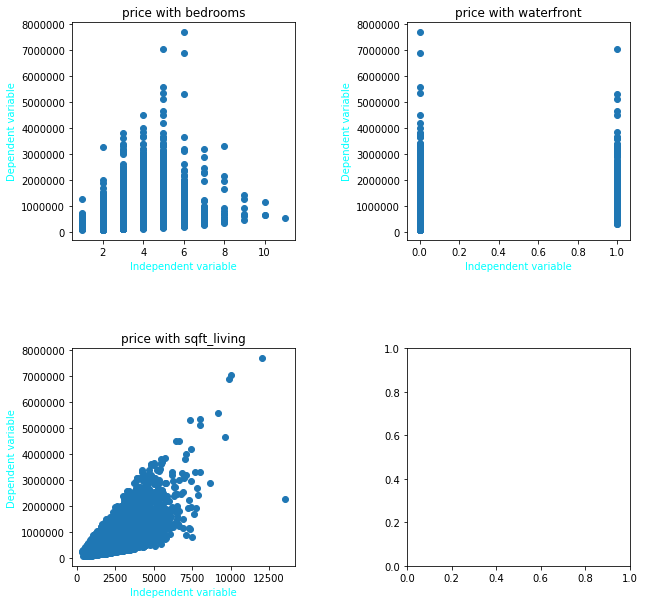

In [55]:
y = regression_baseline.loc[:,['price']]
x = regression_baseline.loc[:,['bedrooms']]
x2 = regression_baseline.loc[:,['waterfront']]
x3 = regression_baseline.loc[:,['sqft_living']]
# x4 = regression_baseline.loc[:,['yr_built']]


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)



ax[0][0].set_xlabel('Independent variable', color="cyan")
ax[0][0].set_ylabel('Dependent variable', color="cyan")
ax[0][1].set_xlabel('Independent variable', color="cyan")
ax[0][1].set_ylabel('Dependent variable', color="cyan")
ax[1][0].set_xlabel('Independent variable', color="cyan")
ax[1][0].set_ylabel('Dependent variable', color="cyan")


ax[0][0].title.set_text('price with bedrooms')
ax[0][0].scatter(x, y)
ax[0][1].title.set_text('price with waterfront')
ax[0][1].scatter(x2, y)
ax[1][0].title.set_text('price with sqft_living')
ax[1][0].scatter(x3, y)






print(regression_baseline.shape)
regression_baseline.head()



## Other regression model:

Bathrooms, waterfront, and grade, maybe floors

In [56]:
other_regression = new_housing_df.loc[:,['price', 'bathrooms', 'waterfront', 'bedrooms']]
other_regression

,price,bathrooms,waterfront,bedrooms
0,221900.0,1.00,0.0,3
1,538000.0,2.25,0.0,3
2,180000.0,1.00,0.0,2
3,604000.0,3.00,0.0,4
4,510000.0,2.00,0.0,3
...,...,...,...,...
21592,360000.0,2.50,0.0,3
21593,400000.0,2.50,0.0,4
21594,402101.0,0.75,0.0,2
21595,400000.0,2.50,0.0,3


### Train test split for it:

In [57]:
#pre-processing
#creating dataframe with all the predictor variables
X = other_regression.loc[:,['bathrooms','waterfront','bedrooms']]

#creating a dataframe with all the target variables
y = other_regression['price']
y = pd.DataFrame(y)


In [58]:
# check X and Y shape
print('X Shape:', X.shape)
print('y Shape:', y.shape)

X Shape: (21420, 3)
y Shape: (21420, 1)


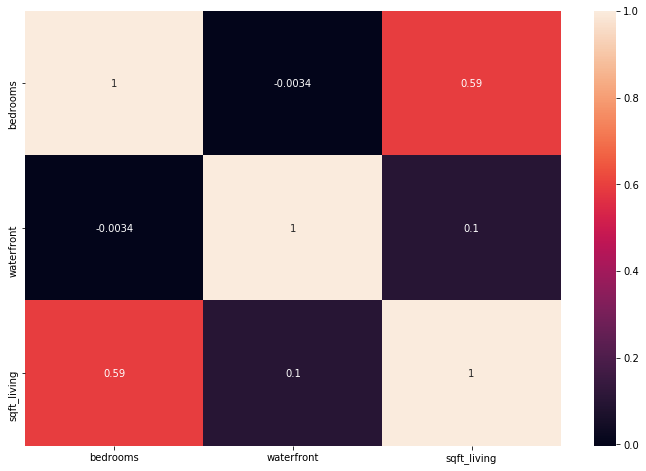

In [59]:
plt.subplots(figsize=(12,8))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

In [60]:
#splitting the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.80)
# Scaling the data
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
# check the shape
print('X_train Shape:', X_train.shape)
print('X_test Shape:', X_test.shape)
print('y_train Shape:', y_train.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (17136, 3)
X_test Shape: (4284, 3)
y_train Shape: (17136, 1)
y_test Shape: (4284, 1)


### Alternate Linear Regression

In [62]:
X = other_regression.drop('price',axis=1)
y = other_regression['price']

In [63]:
# Setting up the LEARNER
X = sm.add_constant(X_train)
model_sm = sm.OLS(y_train,X)

# Actually LEARNING
results = model_sm.fit()

# Evaluating performance
r2 = results.rsquared
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# # Understanding the LEARNED model
est_b = results.params
print(est_b.round(4))

R2 = 0.33
const        -4.350017e+04
bathrooms     2.295862e+05
waterfront    1.023764e+06
bedrooms      2.750324e+04
dtype: float64


In [64]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     2831.
Date:                Fri, 27 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:01:20   Log-Likelihood:            -2.4068e+05
No. Observations:               17136   AIC:                         4.814e+05
Df Residuals:                   17132   BIC:                         4.814e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.35e+04   9269.443     -4.693      0.000   -6.17e+04   -2.53e+04
bathrooms   2.296e+05   3558.843     64.511      0.000    2.23e+05    2.37e+05
waterfront  1.024e+06   2.76e+04     37.058      0.000     9.7e+05    1.08e+06
bedrooms     2.75e+04   3046.475      9.028      0.000    2.15e+04    3.35e+04
==============================================================================
Omnibus:                    13237.942   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           687289.505
Skew:                           3.262   Prob(JB):                         0.00
Kurtosis:                      33.332   Cond. No.                         50.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Homoscedasticity check:

In [65]:
sns.regplot(results.resid, y)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 17136 and the array at index 1 has size 21420

parts of the residuals are homoscedastic but i have some outliers I should have taken care of.

(21420, 4)


,price,bedrooms,waterfront,sqft_living
0,221900.0,3,0.0,1180
1,538000.0,3,0.0,2570
2,180000.0,2,0.0,770
3,604000.0,4,0.0,1960
4,510000.0,3,0.0,1680


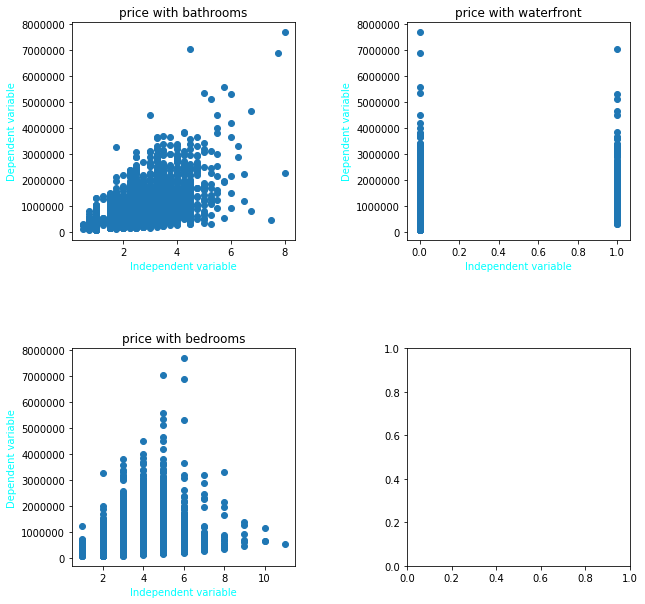

In [66]:
y = other_regression.loc[:,['price']]
x = other_regression.loc[:,['bathrooms']]
x2 = other_regression.loc[:,['waterfront']]
x3 = other_regression.loc[:,['bedrooms']]


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)



ax[0][0].set_xlabel('Independent variable', color="cyan")
ax[0][0].set_ylabel('Dependent variable', color="cyan")
ax[0][1].set_xlabel('Independent variable', color="cyan")
ax[0][1].set_ylabel('Dependent variable', color="cyan")
ax[1][0].set_xlabel('Independent variable', color="cyan")
ax[1][0].set_ylabel('Dependent variable', color="cyan")


ax[0][0].title.set_text('price with bathrooms')
ax[0][0].scatter(x, y)
ax[0][1].title.set_text('price with waterfront')
ax[0][1].scatter(x2, y)
ax[1][0].title.set_text('price with bedrooms')
ax[1][0].scatter(x3, y)






print(regression_baseline.shape)
regression_baseline.head()

### Models equation

$price = 27,503.24 * \beta_{bedrooms} + 1,023,764 * \beta_{waterfront} + 229,586.2 * \beta_{bathrooms} - 43,500.17$

### Interpret Coefficients:

* const        -4.350017e+04 <br>
__The constant means that without any features in place you owe -43,500. This interpretation wouldn't make sense alone as there will always be some feature to subtract it by. Just because it is negative, does not mean it is bad. (It is just placing more value on the other predictors)__
* bathrooms     2.295862e+05 <br>
__The bathrooms coefficient means that for each additional bathroom, the value of your home will increase by ~ 229,000 dollars if all other variables remain constant.__
* waterfront    1.023764e+06 <br>
__The waterfront coefficient means that if your house has a waterfront view expect it's value to be ~1million dollars more.__
* bedrooms      2.750324e+04 <br>
__The bedrooms coefficient means that if for each bedroom in your house, expect a value increase of ~27,500 dollars in house value__

In [67]:
def other_regression_equation(bedrooms, waterfront, bathrooms):
    equation = (27503.24*bedrooms) + (1023764*waterfront)+ (229586.2*bathrooms)- 43500.17
    print("The prediction is: $",equation)

In [68]:
print("check a random house and run it through our model for fun")
print("we will use house #34 for this:")
print("-----------------------------------------------------------------")
new_housing_df.iloc[[34]]

check a random house and run it through our model for fun
we will use house #34 for this:
-----------------------------------------------------------------


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
34,7955080270,322500.0,4,2.75,2060,6659,1.0,0.0,3,7,1981


In [69]:
# going to work on this after the project
print("Input bedrooms, waterfronts, bathrooms")
bedrooms = input()

other_regression_equation(4, 0, 2.75) # much higher than the 322k actual price above

Input bedrooms, waterfronts, bathrooms


 4, 0, 2.75


The prediction is: $ 697874.84


It gets wrong houses with high bedroom counts and puts too much strength on bathrooms as a predictor. I think location of house would serve as a good addition to this model.

# Conclusion

Both of my models are bad in their own ways and place too much emphasis on certain predictors. It would be really nice in the future to add location as a predictor and a few others to correct for these mistakes. 

* __What are the advantages and disadvantages of using both standardised and unstandardised regression coefficients?__ <br>
you can see how much effect one variable has vs another but you cant interpret what that actually means
* __How would you interpret you R2 value?__ <br>
Has a certain amount of error rate.
* __How would you explain R2 to someone without a technical background?__ <br>
The model needs a certain amount of error to make a prediction (it has to be wrong) my R squared is the level of variance of that error within my mode
* __Did you check for multicollinearity?__<br>
Yes and i seperated variables in my regression models to account for this
* __What did you do in order to check for homoscedasticity?__ <br>
Yes and I found my residuals weren't Homoscedastic because I didn't remove outlier houses in my independent variables
* __What other data would you have liked to have access to in order to create a better model?__ <br>
Nearest highscool to each home, and how that high school ranks, crime rates in neighbourhoods, location from shopping and malls, etc.
* __What selection biases are present in the dataset that you are currently using?__ <br>
Sqft_living, and bathrooms.
* __How did you deal with outliers?__ <br>
I took the Median price of houses with the dimensions of my outlier and replaced the value. I could have done this for more houses that fall into the outliers for my features or just dropped them.
* __Were there any non-linear relationships in the dataset that you found in your EDA?__ <br>
None
* __How did you check for the assumption of normally distributed residuals?__ <br>
using an sns regplot to visually see the noise